# Resnets

## Exercise 1

a) Implement and train a network like the one Doug worked out on the board in the lecture (no residual for now). It should take a single scalar input, and each layer should one neuron wide. Additionally you should be able to specify the number of training steps, learning rate, and depth of the network.

b) Measure the gradients of the loss with respect to the weights at each layer. Do the gradients vanish? Try changing the depth and activation function. If you want to see exploding gradients try relu. 

c) Add a skip connection and measure the gradients again with different depths and activation functions. See if you can train a network that actually approximates your chosen function well. Write a few sentences about what changed and why. 

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# code here

### Maybe Helpful Information?

Here is some sample code and examples of output that you can compare your results against. 

A vanishing gradient. 

![](vanishing.png)

Healthier gradient. 

![](fixed.png)


Gradient for a trained network.  

![](converged.png)


The functions I trained on.

```python
def f(x): 
    return x + 0.5 * torch.sin(3 * x)

x = (torch.rand(1) * 2 - 1) * 3.14159
```

Without clipping the gradients there is usually one value that is much larger than the others, which makes plotting difficult. I just clipped those values. 

```python
torch.nn.utils.clip_grad_norm_(W, 1.5)
```

You may also have to clear the gradient between training steps. 
```python
w.grad.zero_()
```

Plotting code
```python
plt.imshow(grad_surface, aspect="auto", origin="lower")
plt.xlabel("layer")
plt.ylabel("training step")
plt.title("gradient magnitudes during training")
plt.colorbar()
plt.show()
```


## Exercise 2

a) Currently this network is 30 layers deep with no skip connection. Add one and report the differences you see. 

b) Uncomment the commented lines in the cells below and replace the MLP class with this class. This network does not use skip connections, just normalization, careful initialization, and gradient clipping. This solves the vanishing gradient problem, yet the performance and speed of convergence is slower than the residual network. Why is that? Record your hypothesis and any differences you notice. 

```python
class MLP(nn.Module):
    def __init__(self, depth, width):
        super().__init__()
        self.inp = nn.Linear(32*32*3, width)
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(width),
                nn.Linear(width, width),
                nn.GELU(),
            ) for _ in range(depth)
        ])
        self.out = nn.Linear(width, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.inp(x)
        for block in self.blocks:
            x = block(x)
        return self.out(x)
```

In [43]:
class MLP(nn.Module):
    def __init__(self, depth, width):
        super().__init__()
        self.inp = nn.Linear(32*32*3, width)
        self.blocks = nn.ModuleList([nn.Sequential(nn.Linear(width, width), nn.ReLU()) for _ in range(depth)])
        self.out = nn.Linear(width, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.inp(x))
        for block in self.blocks:
            x = block(x)             
        return self.out(x)

In [35]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train = datasets.CIFAR10("data", train=True, download=True, transform=transform)
test = datasets.CIFAR10("data", train=False, download=True, transform=transform)
train_loader = DataLoader(train, batch_size=256, shuffle=True, num_workers=0)
test_loader = DataLoader(test, batch_size=256, num_workers=0)

In [44]:
import torch.optim as optim

DEPTH = 30
WIDTH = 64
EPOCHS = 3
LR = 3e-4
PRINT_EVERY = 50

device = "cpu"
model = MLP(DEPTH, WIDTH).to(device)

'''
for m in model.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
'''

opt = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
loss_fn = nn.CrossEntropyLoss()

grad_norms = []

for epoch in range(EPOCHS):
    model.train()
    running = 0.0
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        loss = loss_fn(model(x), y)
        loss.backward()

        total = 0.0
        for p in model.parameters():
            if p.grad is not None:
                total += p.grad.norm().item() ** 2
        grad_norms.append(total ** 0.5)
        
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        opt.step()

        running += loss.item()
        if (i + 1) % PRINT_EVERY == 0:
            print("epoch", epoch, "batch", i + 1, "loss", running / PRINT_EVERY, flush=True)
            running = 0.0

    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    print("epoch", epoch, "test_acc", correct / total, flush=True)

epoch 0 batch 50 loss 2.304242548942566
epoch 0 batch 100 loss 2.3030992460250856
epoch 0 batch 150 loss 2.302938389778137
epoch 0 test_acc 0.1
epoch 1 batch 50 loss 2.3028404474258424
epoch 1 batch 100 loss 2.3027046966552733
epoch 1 batch 150 loss 2.302759675979614
epoch 1 test_acc 0.1
epoch 2 batch 50 loss 2.3025763607025147
epoch 2 batch 100 loss 2.302856512069702
epoch 2 batch 150 loss 2.3027333784103394
epoch 2 test_acc 0.1


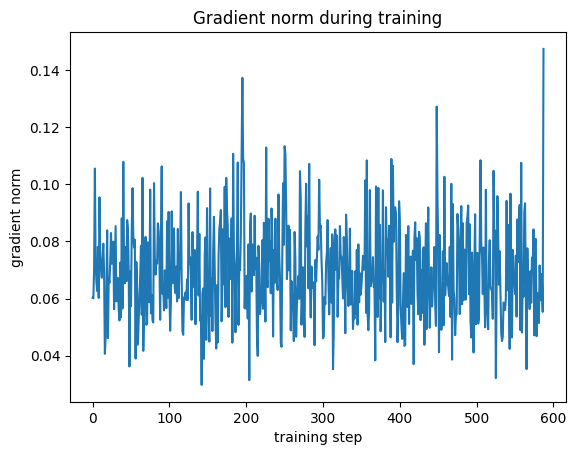

In [45]:
plt.plot(grad_norms)
plt.xlabel("training step")
plt.ylabel("gradient norm")
plt.title("Gradient norm during training")
plt.show()